In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from vars import meaning_dict

In [2]:
all_data = pd.read_excel("./data/data_cn_lc.xlsx")
all_data = all_data.drop(columns=['Unnamed: 0'])
all_data

,Company_name,Company_area,Company_code,Company_industry,CITI,CITI_all_rank,CITI_trade_rank,CATI,CATI_all_rank,CATI_trade_rank,...,rank_Assistant1,rank_Claude-instant0,rank_Claude-instant1,rank_Claude-instant2,rank_GPT-3.5-Turbo0,rank_GPT-3.5-Turbo1,rank_GPT-3.5-Turbo-Instruct0,rank_GPT-3.5-Turbo-Instruct1,rank_GPT-40,rank_Web-Search0
0,李宁有限公司,中国大陆,02331.HK,"纺织, 皮革",39.46,39,11,24.8,284,32,...,B,B-,B,B-,C,B,B,C+,C,-
1,联想集团有限公司,中国大陆,00992.HK,IT/ ICT,46.44,34,9,65.2,15,7,...,A,A-,A+,B,A,A,A,A-,B+,-
2,雅戈尔集团股份有限公司,中国大陆,600177.SH,纺织,6.40,531,108,7.0,929,117,...,C-,A,C+,B,C-,C-,C-,B-,C-,C
3,探路者控股集团股份有限公司,中国大陆,300005.SZ,"纺织, 皮革",2.00,647,59,2.5,1269,59,...,C,A+,C,C-,C-,C,D,D-,C-,-
4,青岛啤酒股份有限公司,中国大陆,600600.SH,啤酒,10.70,358,6,16.0,508,6,...,B+,A,A,A-,B,B,B+,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,周黑鸭国际控股有限公司,中国大陆,01458.HK,食品饮料,7.54,487,48,10.2,753,44,...,C,B,B,B-,B,C-,B,B,C,-
211,嘉士利集团有限公司,中国大陆,01285.HK,食品饮料,8.92,433,44,9.6,782,48,...,C,B-,B+,B,B,B,A-,B+,C+,-
212,绿城中国控股有限公司,中国大陆,03900.HK,房地产建筑,8.08,463,42,16.4,496,9,...,B,B-,A-,B-,A-,A,A,A-,B-,-
213,深圳传音控股股份有限公司,中国大陆,688036.SH,IT/ ICT,9.00,428,60,5.0,1054,94,...,B,C,B,B-,C,B-,C+,C+,B-,-


In [15]:
CE = all_data["SC_CCHHI"].copy()
CE = CE.dropna()
CE = CE.reset_index(drop=True)
CE.describe()

count    90.000000
mean      5.320207
std      12.008817
min       0.000900
25%       0.308368
50%       0.764738
75%       3.498061
max      61.724934
Name: SC_CCHHI, dtype: float64

In [6]:
CE = CE[CE < 1000]
CE

19      0.000000
20    209.012876
65    865.940054
Name: CEmission, dtype: float64

In [25]:
ccxgf_1_dict = {"C":1, "B":2,"BB":3,"BBB-":4,"BBB":5,"BBB+":6, "A-":7,"A":8,"AA-":9,"A+":10}
ccxgf_2_dict = {"B":1,"BB":2,"BBB-":3,"BBB":4,"BBB+":5, "A-":6,"A":7,"AA-":8,"AA":9, "A+": 10}
ccxi_dict = {'na':0, "B":1,"BB":2,"BBB-":3,"BBB":4,"BBB+":5, "A-":6,"A":7,"AA-":8,"AA":9, "A+": 10}
iigf_dict = {'na':0, "D-":1,"D":2,"D+":3,"C-":4,"C":5, "C+":6,"B-":7,"B":8,"B+":9, "A-": 10, "A":11, "A+":12}
syntaogf_dict = {'na':0, "C+":1,"B-":2,"B":3,"B+":4,"A-":5, "A":6}

In [28]:
esg_ccxgf_1 = all_data["Environment"].apply(lambda x: ccxgf_1_dict[x]).to_numpy()
esg_ccxgf_2 = all_data["ESG_ccxgf"].apply(lambda x: ccxgf_2_dict[x]).to_numpy()
esg_ccxi = all_data["ESG_ccxi"].fillna("na").apply(lambda x: ccxi_dict[x]).to_numpy()
esg_iigf = all_data["ESG_iigf"].fillna("na").apply(lambda x: iigf_dict[x]).to_numpy()
esg_iigf_sf = all_data["ESG_iigf_sf"].fillna("na").apply(lambda x: iigf_dict[x]).to_numpy()
esg_syntaogf = all_data["ESG_syntaogf"].fillna("na").apply(lambda x: syntaogf_dict[x]).to_numpy()

In [59]:
esg_gt = [esg_ccxgf_1, esg_ccxgf_2, esg_ccxi, esg_iigf, esg_iigf_sf, esg_syntaogf]

In [51]:
assistant_1_dict = {"N/":0, "E":1, "D-": 2,"D":3,"C-":4,"C":5,"C+":6,"B-":7,"B":8,"B+":9,"A-":10,"A":11,"A+":12}
assistant_2_dict = {"D":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}
assistant_3_dict = {"D-": 1,"D":2,"C-":3,"C":4,"C+":5,"B-":6,"B":7,"B+":8,"A-":9,"A":10,"A+":11}
chatgpt_1_dict = {"D":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}
chatgpt_2_dict = {"D-":1,"D":2,"D+":3,"C-":4,"C":5,"C+":6,"B-":7,"B":8,"B+":9,"A-":10,"A":11,"A+":12}
chatgpt_3_dict = {"D-":1,"D":2,"D+":3,"C-":4,"C":5,"C+":6,"B-":7,"B":8,"B+":9,"A-":10,"A":11,"A+":12}
gpt3_5_t_1_dict = {"D":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}
gpt3_5_t_2_dict = {"D":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}
gpt3_5_t_3_dict = {"D":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}
gpt3_5_i_1_dict = {"D-":1,"D":2,"D+":3,"C-":4,"C":5,"C.":5,"C ":5,"C+":6,"B-":7,"B":8,"B.":8,"B+":9,"A-":10,"A":11,"A+":12}
gpt3_5_i_2_dict = {"D":1,"D+":2,"C-":3,"C":4,"C+":5,"B-":6,"B":7,"B+":8,"A-":9,"A":10,"A+":11}
gpt3_5_i_3_dict = {"D-":1,"D":2,"C-":3,"C":4,"C+":5,"B-":6,"B":7,"B+":8,"A-":9,"A":10,"A+":11}
gpt4_dict = {"D":1,"D+":2,"C-":3,"C":4,"C+":5,"B-":6,"B":7,"B+":8,"A-":9,"A":10,"A+":11}
claude_1_dict = {"C-":1,"C":2,"C+":3,"B-":4,"B":5,"B+":6,"A-":7,"A":8,"A+":9}
claude_2_dict = {"C-":1,"C":2,"C+":3,"B-":4,"B":5,"B+":6,"A-":7,"A":8,"A+":9}
claude_3_dict = {"C-":1,"C":2,"C+":3,"B-":4,"B":5,"B+":6,"A-":7,"A":8}

In [52]:
esg_assistant_1 = all_data["rank_Assistant"].apply(lambda x: assistant_1_dict[x]).to_numpy()
esg_assistant_2 = all_data["rank_Assistant0"].apply(lambda x: assistant_2_dict[x]).to_numpy()
esg_assistant_3 = all_data["rank_Assistant1"].apply(lambda x: assistant_3_dict[x]).to_numpy()
esg_chatgpt_1 = all_data["rank_ChatGPT"].apply(lambda x: chatgpt_1_dict[x]).to_numpy()
esg_chatgpt_2 = all_data["rank_ChatGPT0"].apply(lambda x: chatgpt_2_dict[x]).to_numpy()
esg_chatgpt_3 = all_data["rank_ChatGPT1"].apply(lambda x: chatgpt_3_dict[x]).to_numpy()
esg_gpt3_5_t_1 = all_data["rank_GPT-3.5-Turbo"].apply(lambda x: gpt3_5_t_1_dict[x]).to_numpy()
esg_gpt3_5_t_2 = all_data["rank_GPT-3.5-Turbo0"].apply(lambda x: gpt3_5_t_2_dict[x]).to_numpy()
esg_gpt3_5_t_3 = all_data["rank_GPT-3.5-Turbo1"].apply(lambda x: gpt3_5_t_3_dict[x]).to_numpy()
esg_gpt3_5_i_1 = all_data["rank_GPT-3.5-Turbo-Instruct"].apply(lambda x: gpt3_5_i_1_dict[x]).to_numpy()
esg_gpt3_5_i_2 = all_data["rank_GPT-3.5-Turbo-Instruct0"].apply(lambda x: gpt3_5_i_2_dict[x]).to_numpy()
esg_gpt3_5_i_3 = all_data["rank_GPT-3.5-Turbo-Instruct1"].apply(lambda x: gpt3_5_i_3_dict[x]).to_numpy()
esg_gpt4 = all_data["rank_GPT-40"].apply(lambda x: gpt4_dict[x]).to_numpy()
esg_claude_1 = all_data["rank_Claude-instant0"].apply(lambda x: claude_1_dict[x]).to_numpy()
esg_claude_2 = all_data["rank_Claude-instant1"].apply(lambda x: claude_2_dict[x]).to_numpy()
esg_claude_3 = all_data["rank_Claude-instant2"].apply(lambda x: claude_3_dict[x]).to_numpy()

In [53]:
np.unique(esg_claude_3)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [54]:
esg_pr = [esg_assistant_1, esg_assistant_2, esg_assistant_3, esg_chatgpt_1, esg_chatgpt_2, esg_chatgpt_3, esg_gpt3_5_t_1, esg_gpt3_5_t_2, esg_gpt3_5_t_3, esg_gpt3_5_i_1, esg_gpt3_5_i_2, esg_gpt3_5_i_3, esg_gpt4, esg_claude_1, esg_claude_2, esg_claude_3]

In [57]:
def re_histogram(esg, p):
    hist = []
    for i in range(0,int(esg.max())+1):
        hist = np.append(hist, np.sum(esg == i))
    re_hist = np.zeros(p)
    re_dict = {}
    partition = np.round(hist.sum()/p)
    index = 0
    for i,v in enumerate(hist):
        if v <= partition - re_hist[index]:
            re_hist[index] += v
            re_dict[i] = index
        else:
            if v + re_hist[index] > partition * 1.2:
                index += 1
                if index == p:
                    index = p - 1
                    re_hist[index] += v
                    re_dict[i] = index
                else:
                    re_hist[index] += v
                    re_dict[i] = index
            else:
                re_hist[index] += v
                re_dict[i] = index
                index += 1
                if index == p:
                    index = p - 1
    return re_dict

In [67]:
gt_acu = []
for ii, vi in enumerate(esg_gt):
    gt_index = np.where(vi != 0)[0]
    data_gt = vi[gt_index]
    hist_gt = re_histogram(data_gt, 5)
    data_gt = np.array([hist_gt[i] for i in data_gt])
    pr_acu = []
    for jj, vj in enumerate(esg_pr):
        data_pr = vj[gt_index]
        hist_pr = re_histogram(data_pr, 5)
        data_pr = np.array([hist_pr[i] for i in data_pr])
        acu = len(np.where(data_gt == data_pr)[0])/len(data_gt)
        print(mean_squared_error(data_gt, data_pr), r2_score(data_gt, data_pr), acu)
        pr_acu.append(acu)
        print(ii, jj)
    pr_acu = np.array(pr_acu)
    print(max(pr_acu), np.argmax(pr_acu))
    gt_acu.append(pr_acu.mean())
print(max(gt_acu), np.argmax(gt_acu))





2.4465116279069767 -0.37435286683032354 0.30697674418604654
0 0
2.8046511627906976 -0.5755414043701237 0.25116279069767444
0 1
2.744186046511628 -0.5415745084218457 0.2651162790697674
0 2
2.883720930232558 -0.6199596529178717 0.24651162790697675
0 3
2.6790697674418604 -0.5049947743237002 0.2558139534883721
0 4
2.395348837209302 -0.3456116471817805 0.24186046511627907
0 5
2.7255813953488373 -0.5311231558223755 0.30697674418604654
0 6
2.8465116279069766 -0.5990569477189314 0.3023255813953488
0 7
3.027906976744186 -0.7009576355637652 0.26976744186046514
0 8
2.9209302325581397 -0.640862358116812 0.2744186046511628
0 9
3.227906976744186 -0.8133096760080694 0.25116279069767444
0 10
2.5767441860465117 -0.44751233502661436 0.29767441860465116
0 11
2.4232558139534883 -0.3612886760809857 0.2837209302325581
0 12
2.5953488372093023 -0.45796368762608464 0.2651162790697674
0 13
2.9302325581395348 -0.6460880344165472 0.2930232558139535
0 14
2.8232558139534882 -0.5859927569695937 0.2930232558139535
0 

In [58]:
re_histogram(esg_gpt3_5_i_1, 6)

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 1,
 5: 2,
 6: 2,
 7: 3,
 8: 3,
 9: 4,
 10: 4,
 11: 5,
 12: 5}

In [55]:
for i in esg_gf:
    for j in esg_pr:
        print(len(np.where(i == j)[0])/len(i))

0.046511627906976744
0.19534883720930232
0.07906976744186046
0.11162790697674418
0.06511627906976744
0.06976744186046512
0.12558139534883722
0.05116279069767442
0.06976744186046512
0.06511627906976744
0.023255813953488372
0.046511627906976744
0.08837209302325581
0.19534883720930232
0.16744186046511628
0.16279069767441862
0.07906976744186046
0.13488372093023257
0.17674418604651163
0.09767441860465116
0.07906976744186046
0.10232558139534884
0.12093023255813953
0.12093023255813953
0.13488372093023257
0.09302325581395349
0.05581395348837209
0.08372093023255814
0.13023255813953488
0.14418604651162792
0.17674418604651163
0.12558139534883722
0.07906976744186046
0.13023255813953488
0.17674418604651163
0.08837209302325581
0.07906976744186046
0.10232558139534884
0.11627906976744186
0.11627906976744186
0.12558139534883722
0.09302325581395349
0.05116279069767442
0.08837209302325581
0.13023255813953488
0.13953488372093023
0.17209302325581396
0.12093023255813953
0.10232558139534884
0.088372093023255

In [ ]:
esg_ccxgf_1

In [7]:
result = pd.read_excel("./result_rank-GPT4.xlsx")
result = result.drop(columns=['Unnamed: 1'])
result.fillna(0.0, inplace=True)
result

,Company_name,Company_area,Company_code,Company_industry,CITI,CITI_all_rank,CITI_trade_rank,CATI,CATI_all_rank,CATI_trade_rank,CEmissReduce,CEmission,SC_CC,SC_PC,SC_CCHHI,SC_PCHHI,SC_SCC
0,李宁有限公司,中国大陆,02331.HK,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,联想集团有限公司,中国大陆,00992.HK,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,雅戈尔集团股份有限公司,中国大陆,600177.SH,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,探路者控股集团股份有限公司,中国大陆,300005.SZ,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4,青岛啤酒股份有限公司,中国大陆,600600.SH,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,周黑鸭国际控股有限公司,中国大陆,01458.HK,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,嘉士利集团有限公司,中国大陆,01285.HK,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
211,绿城中国控股有限公司,中国大陆,03900.HK,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
212,深圳传音控股股份有限公司,中国大陆,688036.SH,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [8]:
np.where(result["SC_CCHHI"]==" ")

(array([], dtype=int64),)

In [9]:
vals = result.columns.values.tolist()[3:]

In [10]:
vals

['Company_industry',
 'CITI',
 'CITI_all_rank',
 'CITI_trade_rank',
 'CATI',
 'CATI_all_rank',
 'CATI_trade_rank',
 'CEmissReduce',
 'CEmission',
 'SC_CC',
 'SC_PC',
 'SC_CCHHI',
 'SC_PCHHI',
 'SC_SCC']

In [11]:
rate = []
for val in vals:
    print(val, result[val].sum()/len(result[val]))
    rate.append(result[val].sum()/len(result[val]))

Company_industry 0.1822429906542056
CITI 0.6588785046728972
CITI_all_rank 0.46261682242990654
CITI_trade_rank 0.602803738317757
CATI 0.8130841121495327
CATI_all_rank 0.1542056074766355
CATI_trade_rank 0.1542056074766355
CEmissReduce 0.6448598130841121
CEmission 0.4953271028037383
SC_CC 0.3644859813084112
SC_PC 0.3878504672897196
SC_CCHHI 0.056074766355140186
SC_PCHHI 0.13551401869158877
SC_SCC 0.6588785046728972


In [12]:
data = pd.read_excel("./data/data_cn_lc.xlsx")
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Company_name,Company_area,Company_code,Company_industry,CITI,CITI_all_rank,CITI_trade_rank,CATI,CATI_all_rank,CATI_trade_rank,...,rank_Assistant1,rank_Claude-instant0,rank_Claude-instant1,rank_Claude-instant2,rank_GPT-3.5-Turbo0,rank_GPT-3.5-Turbo1,rank_GPT-3.5-Turbo-Instruct0,rank_GPT-3.5-Turbo-Instruct1,rank_GPT-40,rank_Web-Search0
0,李宁有限公司,中国大陆,02331.HK,"纺织, 皮革",39.46,39,11,24.8,284,32,...,B,B-,B,B-,C,B,B,C+,C,-
1,联想集团有限公司,中国大陆,00992.HK,IT/ ICT,46.44,34,9,65.2,15,7,...,A,A-,A+,B,A,A,A,A-,B+,-
2,雅戈尔集团股份有限公司,中国大陆,600177.SH,纺织,6.40,531,108,7.0,929,117,...,C-,A,C+,B,C-,C-,C-,B-,C-,C
3,探路者控股集团股份有限公司,中国大陆,300005.SZ,"纺织, 皮革",2.00,647,59,2.5,1269,59,...,C,A+,C,C-,C-,C,D,D-,C-,-
4,青岛啤酒股份有限公司,中国大陆,600600.SH,啤酒,10.70,358,6,16.0,508,6,...,B+,A,A,A-,B,B,B+,B,B,B


In [27]:
industry = np.unique(data["Company_industry"])
industry_code = np.zeros(len(industry))
industry_dict = dict(zip(industry, industry_code))

In [28]:
for i, v in enumerate(industry):
    industry_dict[v] = len(np.where(data["Company_industry"] == v)[0])

In [29]:
industry_dict

{'IT/ ICT': 17,
 'IT/ ICT, 光伏设备': 2,
 'IT/ ICT, 家电': 3,
 '乳制品': 9,
 '互联网平台': 3,
 '光伏设备': 13,
 '化工, 家装': 1,
 '医药': 12,
 '啤酒': 4,
 '家电': 8,
 '家电, 光伏设备': 1,
 '家电, 家装': 2,
 '家装': 11,
 '房地产建筑': 34,
 '日化': 8,
 '汽车': 13,
 '汽车, 电池及电池材料': 1,
 '汽车零部件': 6,
 '玩具': 2,
 '白酒': 9,
 '皮革': 3,
 '纸业': 13,
 '纺织': 11,
 '纺织, 皮革': 6,
 '纺织, 钢铁': 1,
 '自行车/助力车': 4,
 '零售, 互联网平台': 1,
 '食品饮料': 15,
 '食品饮料, 乳制品': 1,
 '餐饮': 1}

In [18]:
hist

(array([19.,  3., 12., 13., 13.,  4.,  9.,  2., 45.,  8., 13.,  7.,  2.,
        12., 13., 17.,  1.,  5., 15.,  2.]),
 array([ 1.  ,  2.45,  3.9 ,  5.35,  6.8 ,  8.25,  9.7 , 11.15, 12.6 ,
        14.05, 15.5 , 16.95, 18.4 , 19.85, 21.3 , 22.75, 24.2 , 25.65,
        27.1 , 28.55, 30.  ]),
 <BarContainer object of 20 artists>)

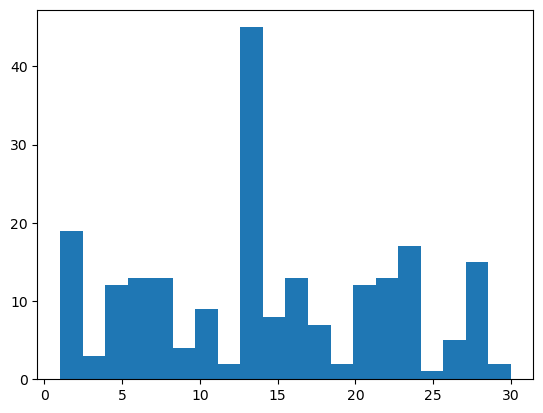

In [17]:
hist=plt.hist(data["Company_industry"].apply(lambda x: industry_dict[x]), bins=20)

In [13]:
bands = data.columns.to_list()
bands = [band for band in bands if "Band" in band]

In [14]:
data_bands = data[bands].copy()
data_bands[data_bands == "grey"] = 0
data_bands[data_bands == "green"] = 1

In [27]:
result_band = pd.read_excel("./result_advise.xlsx")

In [28]:
result_band.fillna(0.0, inplace=True)

In [29]:
bands_r = result_band.columns.to_list()[1:]

In [30]:
data_bands

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_18,Band_19,Band_20,Band_21,Band_22,Band_23,Band_24,Band_25,Band_26,Band_27
0,1,0,1,1,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,0,0
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,1,1,1,1,0
211,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,0,0
212,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,1,1,0
213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
bands_r

['供应链（范围3）政策宣示',
 '供应链（范围3）测算披露',
 '供应链（范围3）目标设定',
 '供应链（范围3）目标绩效',
 '供应链（范围3）供应商企业自主开展碳管理',
 '范围1+2 政策宣示',
 '范围1+2 测算披露',
 '范围1+2 目标设定',
 '范围1+2 目标绩效',
 '范围1+2 自身减排行动']

In [32]:
all_correct = 0
ab_correct = 0
wrong_index = []
wrong_record = np.zeros((len(data), len(bands_r)))
for i in range(0, len(data)):
    data_1 = data_bands.iloc[i]
    correct = np.zeros(len(bands_r))
    band_index = 0
    data_index = 0
    while data_index < len(bands):
        if bands_r[band_index] not in meaning_dict[bands[data_index]]:
            band_index += 1
        correct[band_index] += data_1[bands[data_index]]
        data_index += 1
    correct = [ 1 if float(i) > 0 else 0 for i in correct]
    correct = np.array(correct)
    pr_correct = [ 1 if i > 0 else 0 for i in result_band.iloc[i][bands_r]]
    pr_correct = np.array(pr_correct)
    wrong = np.where(correct != pr_correct)[0]
    wrong_record[i][wrong] = 1
    if wrong.shape[0] == 0:
        ab_correct += 1
    else:
        wrong_index.append(i)
    all_correct += np.where(correct == pr_correct)[0].shape[0]


In [33]:
1 - wrong_record.sum(axis=0)/len(data) #GPT3

array([0.97674419, 0.9627907 , 0.94883721, 0.96744186, 0.97674419,
       0.95348837, 0.89302326, 0.86511628, 0.95348837, 0.90697674])

In [26]:
1 - wrong_record.sum(axis=0)/len(data) #GPT4

array([0.98139535, 0.96744186, 0.95348837, 0.98139535, 0.98604651,
       0.97209302, 0.92093023, 0.89302326, 0.95348837, 0.95348837])

In [11]:
all_correct/len(data_bands)/len(bands_r) #GPT4

0.9562790697674419

In [94]:
all_correct/len(data_bands)/len(bands_r) #GPT3

0.9404651162790698

In [93]:
ab_correct/len(data_bands)

0.6930232558139535

In [74]:
all_correct/len(data)/len(bands_r)

0.9009302325581394

In [96]:
np.save("wrong_index.npy",wrong_index)

In [97]:
wrong_index

[0,
 2,
 5,
 7,
 10,
 15,
 16,
 17,
 19,
 23,
 24,
 34,
 36,
 40,
 43,
 46,
 50,
 58,
 62,
 63,
 65,
 66,
 67,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 79,
 81,
 88,
 90,
 95,
 96,
 112,
 114,
 125,
 128,
 130,
 132,
 133,
 136,
 138,
 140,
 142,
 143,
 148,
 151,
 156,
 157,
 158,
 161,
 166,
 167,
 171,
 181,
 182,
 184,
 191,
 197,
 198,
 202,
 203,
 204]

In [65]:
data_1 = data.iloc[0]
correct = np.zeros(len(bands_r))
band_index = 0
data_index = 0
while data_index < len(bands):
    if bands_r[band_index] not in meaning_dict[bands[data_index]]:
        band_index += 1
    correct[band_index] += data_1[bands[data_index]]
    data_index += 1

    

In [66]:
correct = [ 1 if i > 0 else 0 for i in correct]

In [67]:
correct = np.array(correct)

In [71]:
np.where(correct == result_band.iloc[0][bands_r])[0]

array([0, 1, 2, 3, 4, 5, 6, 8, 9], dtype=int64)

In [4]:
ci_score = zip(data["Company_industry"].unique(), range(len(data["Company_industry"].unique())))
ci_score = dict(ci_score)
ci_score

{'纺织, 皮革': 0,
 'IT/ ICT': 1,
 '纺织': 2,
 '啤酒': 3,
 '汽车': 4,
 '汽车, 电池及电池材料': 5,
 'IT/ ICT, 光伏设备': 6,
 '乳制品': 7,
 '食品饮料': 8,
 '家电': 9,
 '日化': 10,
 '皮革': 11,
 '纸业': 12,
 'IT/ ICT, 家电': 13,
 '房地产建筑': 14,
 '食品饮料, 乳制品': 15,
 '纺织, 钢铁': 16,
 '汽车零部件': 17,
 '白酒': 18,
 '医药': 19,
 '家装': 20,
 '化工, 家装': 21,
 '家电, 家装': 22,
 '自行车/助力车': 23,
 '光伏设备': 24,
 '玩具': 25,
 '互联网平台': 26,
 '零售, 互联网平台': 27,
 '家电, 光伏设备': 28,
 '餐饮': 29}

In [5]:

index = np.random.choice(range(len(data)), size=len(data), replace=False)

In [6]:
index

array([ 24, 140,  53,  73,  18, 109,  70, 160,  66,  99, 120, 205, 161,
       184, 158, 169,   2,  72,  33, 150,  35,  29, 189,  19,  30, 113,
       122,   4, 136,  50, 126,  44, 172,  80, 142, 104,  85,   5, 204,
       114,  48, 200, 153,  62, 173,  22,  38, 166,  54, 152, 206, 139,
       103,  78, 171, 124, 111,  25, 181,  39, 179, 155,  41, 191,  90,
        74, 119, 121,  10,  95,  87, 135, 141, 178, 187, 177,  76, 198,
         8,  63,  86, 131, 188, 208,  52,  64,  71,  97, 149,  68,  59,
        84,  81, 194, 106, 148,  15, 209,  77,  42,  12, 128,  37, 133,
        79, 168, 156,  89, 210,   6, 202, 125,  45,  23,  34, 167,  55,
       117, 144, 134, 110, 159,  46, 157, 164, 203, 123,  28, 183,  31,
       170,  14,  61, 162, 213, 129, 107,  20,  47, 132,  49,  21, 186,
        94, 199,  17, 207,  16,  36,  92, 193, 100,   3, 175, 165, 214,
       196, 195,  26,  27,   7, 197,  98,  91,  82, 127, 145,  43,  69,
       211,   9, 185, 130,  93, 102, 116,  96,  67,  40, 143, 14

In [7]:
gt_environment = data["Environment"]

In [8]:
gt_environment = gt_environment.to_numpy()

In [9]:
np.unique(gt_environment)

array(['A', 'A+', 'A-', 'AA-', 'B', 'BB', 'BBB', 'BBB+', 'BBB-', 'C'],
      dtype=object)

In [10]:
gt_score = {"C":0, "B":1,"BB":2,"BBB-":3,"BBB":4,"BBB+":5,"A-":6,"A":7,"AA-":8,"A+":9}

In [11]:
pr_environment = data["rank_GPT-40"]

In [12]:
pr_environment = pr_environment.to_numpy()

In [13]:
np.unique(pr_environment)

array(['A', 'A+', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-', 'D', 'D+'],
      dtype=object)

In [14]:
pr_score = {"D":0,"D+":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}

In [15]:
gt_esg = [gt_score[i] for i in gt_environment]

In [16]:
pr_esg = [pr_score[i] for i in pr_environment]

In [17]:
gt_esg = np.array(gt_esg)
pr_esg = np.array(pr_esg)

In [18]:
def re_histogram(esg):
    hist = []
    for i in range(0,int(esg.max())+1):
        hist = np.append(hist, np.sum(esg == i))
    re_hist = np.zeros(5)
    re_dict = {}
    partition = np.round(hist.sum()/5)
    index = 0
    for i,v in enumerate(hist):
        if v <= partition - re_hist[index]:
            re_hist[index] += v
            re_dict[i] = index
        else:
            if v + re_hist[index] > partition * 1.2:
                index += 1
                if index == 5:
                    index = 4
                    re_hist[index] += v
                    re_dict[i] = index
                else:
                    re_hist[index] += v
                    re_dict[i] = index
            else:
                re_hist[index] += v
                re_dict[i] = index
                index += 1
                if index == 5:
                    index = 4
    return re_dict

In [19]:
gt_hist = re_histogram(gt_esg)
pr_hist = re_histogram(pr_esg)

In [20]:
re_gt_esg = [gt_hist[i] for i in gt_esg]
re_pr_esg = [pr_hist[i] for i in pr_esg]
re_pr_esg = np.array(re_pr_esg)
re_gt_esg = np.array(re_gt_esg)

In [21]:
np.where(re_gt_esg==re_pr_esg)[0].shape[0]/re_gt_esg.shape[0]

0.2837209302325581

In [26]:
np.where(gt_esg==pr_esg-1)[0].shape[0]/re_gt_esg.shape[0]

0.08372093023255814

In [27]:
np.where(gt_esg==pr_esg+1)[0].shape[0]/re_gt_esg.shape[0]

0.046511627906976744

In [28]:
np.where(gt_esg==pr_esg)[0].shape[0]/re_gt_esg.shape[0]

0.08837209302325581

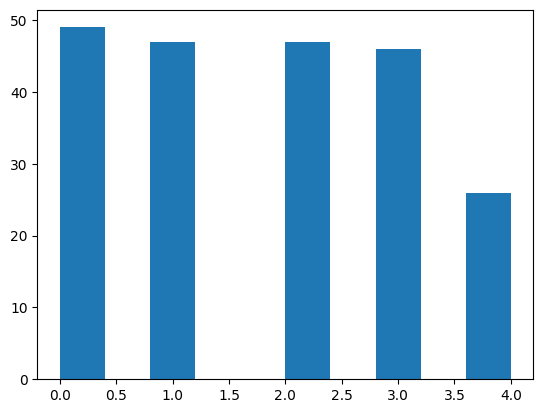

In [68]:
gt_dis = plt.hist(re_gt_esg)[0]

In [31]:
gt_dis

array([49., 47., 47., 15., 19., 12.,  6., 11.,  4.,  5.])

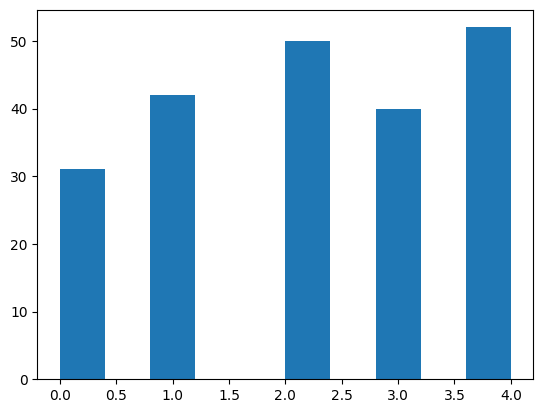

In [69]:
pr_dis =plt.hist(re_pr_esg)[0]

In [29]:
len(np.where(gt_esg == pr_esg)[0])

45

In [30]:
45/len(gt_esg)

0.20930232558139536

In [31]:
def cross_entropy(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

In [43]:
cross_entropy(pr_dis, gt_dis)

-629.4559202993247

In [49]:
len(np.where(gt_esg == pr_esg+1)[0])

16

In [50]:
len(np.where(gt_esg == pr_esg-1)[0])

24

In [51]:
(45+16+24)/len(gt_esg)

0.3953488372093023

In [52]:
pr_score = {"N/":0,"E":0,"D-":0,"D":0, "C-":0, "C":0, "C+":0,"B-":1,"B":1,"B+":1,"A-":2,"A":2,"A+":2}
gt_score = {"C":0, "B":0,"BB":0,"BBB⁻":1,"BBB":1,"BBB⁺":1,"A⁻":2,"A":2,"AA⁻":2,"A⁺":2}

In [53]:
gt_esg = [gt_score[i] for i in gt_environment]
pr_esg = [pr_score[i] for i in pr_environment]

In [54]:
gt_esg = np.array(gt_esg)
pr_esg = np.array(pr_esg)

In [58]:
len(np.where(gt_esg == pr_esg)[0])/len(gt_esg)+len(np.where(gt_esg == pr_esg+1)[0])/len(gt_esg)+len(np.where(gt_esg == pr_esg-1)[0])/len(gt_esg)

0.8883720930232558

In [56]:
len(np.where(gt_esg == pr_esg+1)[0])/len(gt_esg)

0.12093023255813953

In [57]:
len(np.where(gt_esg == pr_esg-1)[0])/len(gt_esg)

0.2930232558139535